## Dependencies

In [1]:
import sys
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition/data')
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition')

In [2]:
import torch
from torch import nn

import pytorch_lightning as pl

import torchaudio.transforms as T
import torch.nn.functional as F

from IPython.display import Audio, display
from data import datasets
from utils.utils import provide_reproducibility

In [3]:
! pip -qqq install ipywidgets==7.7.2

## CUDA device

In [4]:
provide_reproducibility(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Task config

In [5]:
task_type =  'multiclass' # 'all' # binary
percentage = 0.2
model_name = 'M8'
num_channels = 64
    

## Datasets

In [6]:
dir_name = '/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data'  # ubuntu

In [7]:
import importlib

importlib.reload(datasets)

vowel_labels = [
    'IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY',
    'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER',
    'AX','IX', 'AXR', 'AH-H'
    ]
consonant_labels = [
        'B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',     # stops
        'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX',     # nasals
        'JH', 'CH',                                  # affricates
        'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH',  # fricatives
        'L', 'R', 'W', 'Y', 'HH', 'HV', 'EL'         # semivowels_glides
    ]
stops = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q']
nasals = ['M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']
affricates = ['JH', 'CH']
fricatives = ['S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH']
semivowels_glides = ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL']
other_labels = ['H#', 'PAU', 'EPI']

In [8]:
if task_type == 'binary':
    phoneme_classes = {
        'vowels': vowel_labels,
        'consonants': consonant_labels,
        'other': other_labels
    }
    phone_labels = vowel_labels + consonant_labels + other_labels
    labels = ['vowels', 'consonants', 'other']
    phone_codes = phoneme_classes
    phoneme_labeler = datasets.PhonemeLabeler(phoneme_classes=phoneme_classes, mode='.')
elif task_type == 'multiclass':
    phoneme_classes = {
        'vowels': vowel_labels,
        'stops': stops,
        'nasals': nasals,
        'affricates': affricates,
        'fricatives': fricatives,
        'semivowels_glides': semivowels_glides,
        'other': other_labels
    }
    phone_labels = vowel_labels  + other_labels + stops + nasals + affricates + fricatives + semivowels_glides
    labels = ['vowels', 'stops', 'nasals', 'affricates', 'fricatives', 'semivowels_glides', 'other']
    phone_codes = phoneme_classes
    phoneme_labeler = datasets.PhonemeLabeler(phoneme_classes=phoneme_classes, mode='.')
elif task_type == 'all':
    phone_codes = None
    phoneme_labeler=datasets.PhonemeLabeler(mode='default')
    # phoneme_classes = None
    # phoneme_labeler_mode = 'default'


In [9]:

timit_dataset_train = datasets.TIMITDataset(
    usage='train',
    percentage=percentage,
    root_dir=dir_name,
    phone_codes=phone_codes,
    phoneme_labeler=phoneme_labeler,
    description_file_path='../data/timit_description.csv'
    )

timit_dataset_test = datasets.TIMITDataset(
    usage='test',
    percentage=percentage,
    root_dir=dir_name,
    phone_codes=phone_codes,
    phoneme_labeler=phoneme_labeler,
    description_file_path='../data/timit_description.csv'
    )

timit_framerate = timit_dataset_train[0].frame_rate

<Axes: ylabel='phone_class'>

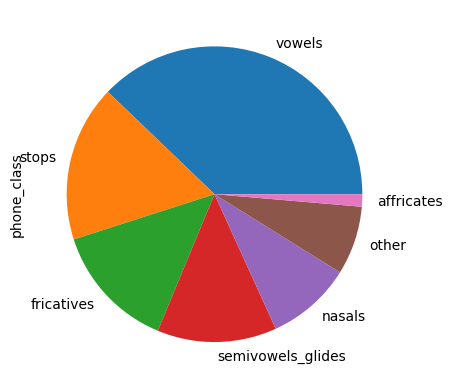

In [10]:
timit_dataset_train.description_table.phone_class.value_counts(normalize=True).plot(kind='pie')

<Axes: ylabel='phone_name'>

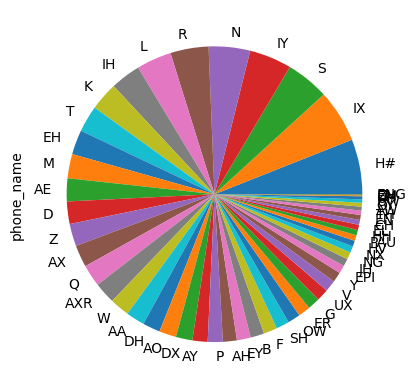

In [11]:
timit_dataset_train.description_table.phone_name.value_counts(normalize=True).plot(kind='pie')

In [12]:
if task_type == 'all':
    labels = timit_dataset_train.description_table.phone_name.unique().tolist()
    
num_of_classes = len(labels)

## Transform

In [13]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)
transform_cpu = T.Resample(orig_freq=timit_framerate, new_freq=8000)

chunk_size = 1024

## Dataloaders

In [14]:
# def label_to_index(phone):
#     index = labels.index(phone)
#     num_labels = len(labels)
#     one_hot = [0] * num_labels
#     one_hot[index] = 1
#     return torch.tensor(one_hot)

def label_to_index(phone):
    # Return the position of the word in labels
    return torch.tensor(labels.index(phone))

def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


# def collate_fn(batch):
#     tensors, targets = [], []

#     for waveform, label, *_ in batch:
#         i, j = 0, chunk_size
#         while j < waveform.shape[1]:
#             # print(waveform.shape)
#             tensors += [waveform[..., i:j]]
#             targets += [label_to_index(label)]

#             i += chunk_size // 2
#             j += chunk_size // 2
#         # else:
#         #     tensors += F.pad(waveform, (0, chunk_size - waveform.shape[0]), 'constant', 0.0)
    
#         # tensors += [waveform[..., :chunk_size]]
#         # targets += [label_to_index(label)]
#     print('finish')
#     tensors = pad_sequence(tensors)
#     targets = torch.stack(targets)

#     return tensors, targets

def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform[..., :chunk_size]]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 12
    pin_memory = True
else:
    num_workers = 12
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))

In [15]:
train_features[0].shape, train_labels.shape

(torch.Size([1, 1024]), torch.Size([256]))

# ПОЧИНИ ПАДДИНГ ТЕНЗОРА WAVEFORM

## Model training

In [16]:
import models
from models import phoneme_recognizer
from models import mixins

importlib.reload(models)
importlib.reload(phoneme_recognizer)
importlib.reload(mixins)

<module 'models.mixins' from '/home/maxim/VisibleSpeech/runtime_speech_recognition/models/mixins.py'>

In [17]:
import torch.nn.functional as F


class M3(nn.Module):
    def __init__(
            self,
            n_input=1,
            n_output=35,
            stride=4,
            conv_kernel=80,
            maxpool_kernel=4,
            n_channel=256
        ):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=conv_kernel, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(maxpool_kernel)
        #
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(maxpool_kernel)

        self.fc1 = nn.Linear(n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = F.avg_pool1d(x, int(x.shape[-1])) # fixme ????
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        # return self.sigmoid(x)

In [18]:
class M5(nn.Module):
    def __init__(
            self,
            n_input=1,
            n_output=35,
            stride=4,
            conv_kernel=80,
            maxpool_kernel=4,
            n_channel=128
        ):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=conv_kernel, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(maxpool_kernel)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(maxpool_kernel)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(maxpool_kernel)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(maxpool_kernel)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(self.bn3(x))
        # print(x.shape)
        x = self.pool3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        # print(x.shape)
        x = F.avg_pool1d(x, x.shape[-1])
        # print(x.shape)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        return F.log_softmax(x, dim=2)

In [19]:
class MBlock(nn.Module):
    def __init__(self, kernel_size, in_chn, out_chn, count):
        super().__init__()
        self.layers = self._init_layers(kernel_size, in_chn, out_chn, count)

    def _init_layers(self, kernel_size, in_chn, out_chn, count):
        layers = list()
        for _ in range(count):
            layers += [
                nn.Conv1d(in_channels=in_chn, out_channels=out_chn, kernel_size=kernel_size),
                nn.BatchNorm1d(out_chn),
                nn.ReLU()
            ]
            in_chn = out_chn

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
class M7(nn.Module):
    def __init__(
            self,
            n_input=1,
            n_output=20,
            stride=4,
            conv_kernel=80,
            maxpool_kernel=4,
            n_channel=64
        ):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=conv_kernel, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(maxpool_kernel)
        ##
        self.conv_layers_2 = MBlock(kernel_size=3, in_chn=n_channel, out_chn=n_channel, count=3)
        self.pool2 = nn.MaxPool1d(maxpool_kernel)
        self.conv_layers_3 = MBlock(kernel_size=3, in_chn=n_channel, out_chn=n_channel * 2, count=3)
        self.pool3 = nn.MaxPool1d(maxpool_kernel)
        ##
        self.fc1 = nn.Linear(n_channel * 2, n_output)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(self.bn1(x))
        # print(x.shape)
        x = self.pool1(x)
        # print(x.shape)

        x = self.conv_layers_2(x)
        # print(x.shape)
        x = self.pool2(x)
        # print(x.shape)

        x = self.conv_layers_3(x)
        # print(x.shape)
        x = self.pool3(x)
        # print(x.shape)


        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)

        return F.log_softmax(x, dim=2)


class M8(nn.Module):
    def __init__(
            self,
            n_input=1,
            n_output=20,
            stride=4,
            conv_kernel=80,
             maxpool_kernel=4,
            n_channel=64
        ):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=conv_kernel, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(maxpool_kernel)
        ##
        self.conv_layers_2 = MBlock(kernel_size=3, in_chn=n_channel, out_chn=n_channel, count=2)
        self.pool2 = nn.MaxPool1d(maxpool_kernel)
        self.conv_layers_3 = MBlock(kernel_size=3, in_chn=n_channel, out_chn=n_channel * 2, count=2)
        self.pool3 = nn.MaxPool1d(maxpool_kernel)
        self.conv_layers_4 = MBlock(kernel_size=2, in_chn=n_channel * 2, out_chn=n_channel * 4, count=3)

        self.fc1 = nn.Linear(n_channel * 4, n_output)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(self.bn1(x))
        # print(x.shape)
        x = self.pool1(x)
        # print(x.shape)

        x = self.conv_layers_2(x)
        # print(x.shape)
        x = self.pool2(x)
        # print(x.shape)

        x = self.conv_layers_3(x)
        # print(x.shape)
        x = self.pool3(x)
        # print(x.shape)

        x = self.conv_layers_4(x)
        # print(x.shape)
        # x = self.pool4(x)
        # print(x.shape)

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)

        return F.log_softmax(x, dim=2)

In [20]:
from pathlib import Path

# model params
n_input = 1
n_output = num_of_classes
stride = 2
kernel_size = 10
maxpool_kernel = 4
n_channel = num_channels
optimizer = 'adadelta'
lr = 3e-1


# experiment_name = f'no resample, chunk_size={chunk_size}, kernel={kernel_size}, stride={stride}, n_channels={n_channel}, optimizer={optimizer}, lr={lr}'
experiment_name = f'(conv={kernel_size},{stride}, maxpool={maxpool_kernel} lr={lr})'
project_name = 'Различные количества классов'

run_name = f'{model_name}|num of classes:{num_of_classes}|params:{experiment_name}'
model_path = Path(f'/home/maxim/VisibleSpeech/runtime_speech_recognition/models/{model_name}')
experiment_path_model = model_path / experiment_name

logs_path = experiment_path_model / 'logs'
cp_path = experiment_path_model / 'cp'
logs_path.mkdir(parents=True, exist_ok=True)
cp_path.mkdir(parents=True, exist_ok=True)

In [47]:
models_dict = {
    'M3': M3,
    'M5': M5,
    'M7': M7,
    'M8': M8
}

model = models_dict[model_name]

example = torch.rand(1, 1, 1024)
test_model = model(
    n_input=n_input,
    n_output=num_of_classes,
    stride=stride,
    maxpool_kernel=maxpool_kernel,
    conv_kernel=kernel_size,
    n_channel=n_channel
)

In [48]:
%%time
test_model(example)

CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 3.75 ms


tensor([[[-1.9762, -2.0214, -2.0917, -1.9113, -1.7931, -1.7504, -2.1418]]],
       grad_fn=<LogSoftmaxBackward0>)

In [22]:
model

__main__.M8

In [23]:
from pathlib import Path
from models.phoneme_recognizer import PhonemeRecognizer, AudioPreprocessorCallback
from pytorch_lightning.callbacks import ModelCheckpoint


model = PhonemeRecognizer(
    acoustic_model=model,
    num_of_classes=num_of_classes,
    model_params=dict(
        n_input=n_input,
        n_output=num_of_classes,
        stride=stride,
        maxpool_kernel=maxpool_kernel,
        conv_kernel=kernel_size,
        n_channel=n_channel
    ),
    loss_criterion=nn.NLLLoss(),
    lr=lr,
    target_type=None
)
config_params = dict(
    n_input=n_input,
    n_output=num_of_classes,
    stride=stride,
    n_channel=n_channel,
    optimizer=optimizer,
    conv_kernel=kernel_size,
    maxpool_kernel=maxpool_kernel,
    lr=lr
)

model_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=cp_path,
    filename=model_name + '_' + experiment_name + '{epoch:02d}-{val_loss:.2f}',
    save_top_k=-1,
    mode='min'
)
preprocessor_callback = AudioPreprocessorCallback(transform=transform, device=device)
callbacks = [model_checkpoint_callback]

In [24]:
from pytorch_lightning.loggers import WandbLogger

n_epochs = 15

logger = WandbLogger(
    project=project_name,
    name=run_name,
    save_dir=logs_path,
    log_model='all'
)

trainer = pl.Trainer(
    logger=logger,
    default_root_dir=logs_path,
    accelerator='gpu',
    devices=1,
    callbacks=callbacks,
    max_epochs=n_epochs,
    log_every_n_steps=10)

logger.watch(model, log='all', log_graph=True)
trainer.fit(model, train_loader, test_loader)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: crazy_historian. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/maxim/VisibleSpeech/env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/maxim/VisibleSpeech/runtime_speech_recognition/models/M8/(conv=10,2, maxpool=4 lr=0.3)/cp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | loss_criterion     | NLLLoss          | 0     
1 | train_metrics      | MetricCollection | 0     
2 | val_metrics        | MetricCollection | 0     
3 | test_metrics       | MetricCollection | 0     
4 | checkpoint_metrics | MetricCollection | 0     
5 | acoustic_model     | M8   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [25]:
# filepath = f'{model_name}_{experiment_name}'
# input_sample = train_features[0].unsqueeze(0)

# model.to_onnx(filepath, input_sample, export_params=True)

## Time of execution

In [121]:
model_name = 'M8'

example = torch.rand(1, 1, 1024)

n_channel = 64
num_of_classes = 61

test_model = models_dict[model_name](
    n_input=n_input,
    n_output=num_of_classes,
    stride=stride,
    maxpool_kernel=maxpool_kernel,
    conv_kernel=kernel_size,
    n_channel=n_channel
)

In [122]:
%%timeit
test_model(example)

1.23 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
